# TensorFlow roBERTa Starter - LB 0.705
This notebook is a TensorFlow template for solving Kaggle's Tweet Sentiment Extraction competition as a question and answer roBERTa formulation. In this notebook, we show how to tokenize the data, create question answer targets, and how to build a custom question answer head for roBERTa in TensorFlow. Note that HuggingFace transformers don't have a `TFRobertaForQuestionAnswering` so we must make our own from `TFRobertaModel`. This notebook can achieve LB 0.715 with some modifications. Have fun experimenting!

You can also run this code offline and it will save the best model weights during each of the 5 folds of training. Upload those weights to a private Kaggle dataset and attach to this notebook. Then you can run this notebook with the line `model.fit()` commented out, and this notebook will instead load your offline models. It will use your offline models to predict oof and predict test. Hence this notebook can easily be converted to an inference notebook. An inference notebook is advantageous because it will only take 10 minutes to commit and submit instead of 2 hours. Better to train 2 hours offline separately.

fom: [Kaggle](https://www.kaggle.com/code/cdeotte/tensorflow-roberta-0-705/notebook)

# Load Libraries, Data, Tokenizer
We will use HuggingFace transformers [here][1]

[1]: https://huggingface.co/transformers/

In [2]:
import pandas as pd, numpy as np
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.mixed_precision import LossScaleOptimizer, set_global_policy

# Enable mixed precision globally
set_global_policy('mixed_float16')

from sklearn.model_selection import StratifiedKFold
print('TF version',tf.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
from transformers import *
import tokenizers


/home/amd/miniconda3/envs/senta/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 4070 Laptop GPU, compute capability 8.9


2024-10-24 15:16:22.508385: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:925] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-10-24 15:16:22.533070: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:925] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-10-24 15:16:22.533108: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:925] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-10-24 15:16:22.533708: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:925] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


TF version 2.7.0
Num GPUs Available:  1


In [4]:
MAX_LEN = 96
PATH = '../config/'

vocap_pth = PATH+'vocab-roberta-base.json'
merges_pth = PATH+'merges-roberta-base.txt'
    
tokenizer = tokenizers.ByteLevelBPETokenizer(
    lowercase=True,
    add_prefix_space=True
)
tokenizer.from_file(vocap_pth, merges_pth)
sentiment_id = {'positive': 1313, 'negative': 2430, 'neutral': 7974}
train = pd.read_csv('../data/train.csv').fillna('')
train.head()

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


# Training Data
We will now convert the training data into arrays that roBERTa understands. Here are example inputs and targets: 
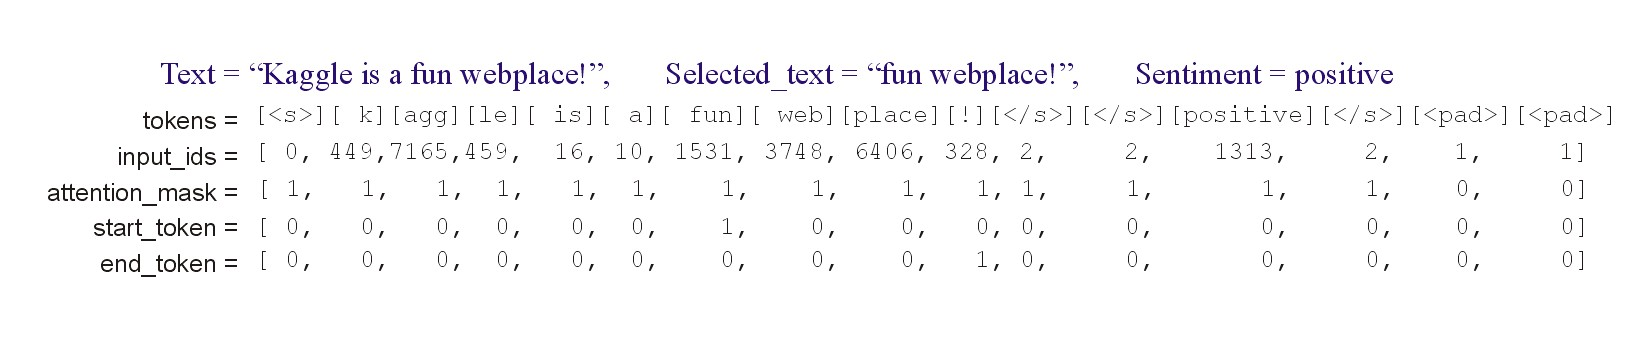
The tokenization logic below is inspired by Abhishek's PyTorch notebook [here][1].

[1]: https://www.kaggle.com/abhishek/roberta-inference-5-folds

In [5]:
ct = train.shape[0]
input_ids = np.ones((ct,MAX_LEN),dtype='int32')
attention_mask = np.zeros((ct,MAX_LEN),dtype='int32')
token_type_ids = np.zeros((ct,MAX_LEN),dtype='int32')
start_tokens = np.zeros((ct,MAX_LEN),dtype='int32')
end_tokens = np.zeros((ct,MAX_LEN),dtype='int32')

for k in range(train.shape[0]):
    
    # FIND OVERLAP
    text1 = " "+" ".join(train.loc[k,'text'].split())
    text2 = " ".join(train.loc[k,'selected_text'].split())
    idx = text1.find(text2)
    chars = np.zeros((len(text1)))
    chars[idx:idx+len(text2)]=1
    if text1[idx-1]==' ': chars[idx-1] = 1 
    enc = tokenizer.encode(text1) 
        
    # ID_OFFSETS
    offsets = []; idx=0
    for t in enc.ids:
        w = tokenizer.decode([t])
        offsets.append((idx,idx+len(w)))
        idx += len(w)
    
    # START END TOKENS
    toks = []
    for i,(a,b) in enumerate(offsets):
        sm = np.sum(chars[a:b])
        if sm>0: toks.append(i) 
        
    s_tok = sentiment_id[train.loc[k,'sentiment']]
    input_ids[k,:len(enc.ids)+5] = [0] + enc.ids + [2,2] + [s_tok] + [2]
    attention_mask[k,:len(enc.ids)+5] = 1
    if len(toks)>0:
        start_tokens[k,toks[0]+1] = 1
        end_tokens[k,toks[-1]+1] = 1

# Test Data
We must tokenize the test data exactly the same as we tokenize the training data

In [6]:
test = pd.read_csv('../data/test.csv').fillna('')

ct = test.shape[0]
input_ids_t = np.ones((ct,MAX_LEN),dtype='int32')
attention_mask_t = np.zeros((ct,MAX_LEN),dtype='int32')
token_type_ids_t = np.zeros((ct,MAX_LEN),dtype='int32')

for k in range(test.shape[0]):
        
    # INPUT_IDS
    text1 = " "+" ".join(test.loc[k,'text'].split())
    enc = tokenizer.encode(text1)                
    s_tok = sentiment_id[test.loc[k,'sentiment']]
    input_ids_t[k,:len(enc.ids)+5] = [0] + enc.ids + [2,2] + [s_tok] + [2]
    attention_mask_t[k,:len(enc.ids)+5] = 1

# Build roBERTa Model
We use a pretrained roBERTa base model and add a custom question answer head. First tokens are input into `bert_model` and we use BERT's first output, i.e. `x[0]` below. These are embeddings of all input tokens and have shape `(batch_size, MAX_LEN, 768)`. Next we apply `tf.keras.layers.Conv1D(filters=1, kernel_size=1)` and transform the embeddings into shape `(batch_size, MAX_LEN, 1)`. We then flatten this and apply `softmax`, so our final output from `x1` has shape `(batch_size, MAX_LEN)`. These are one hot encodings of the start tokens indicies (for `selected_text`). And `x2` are the end tokens indicies.

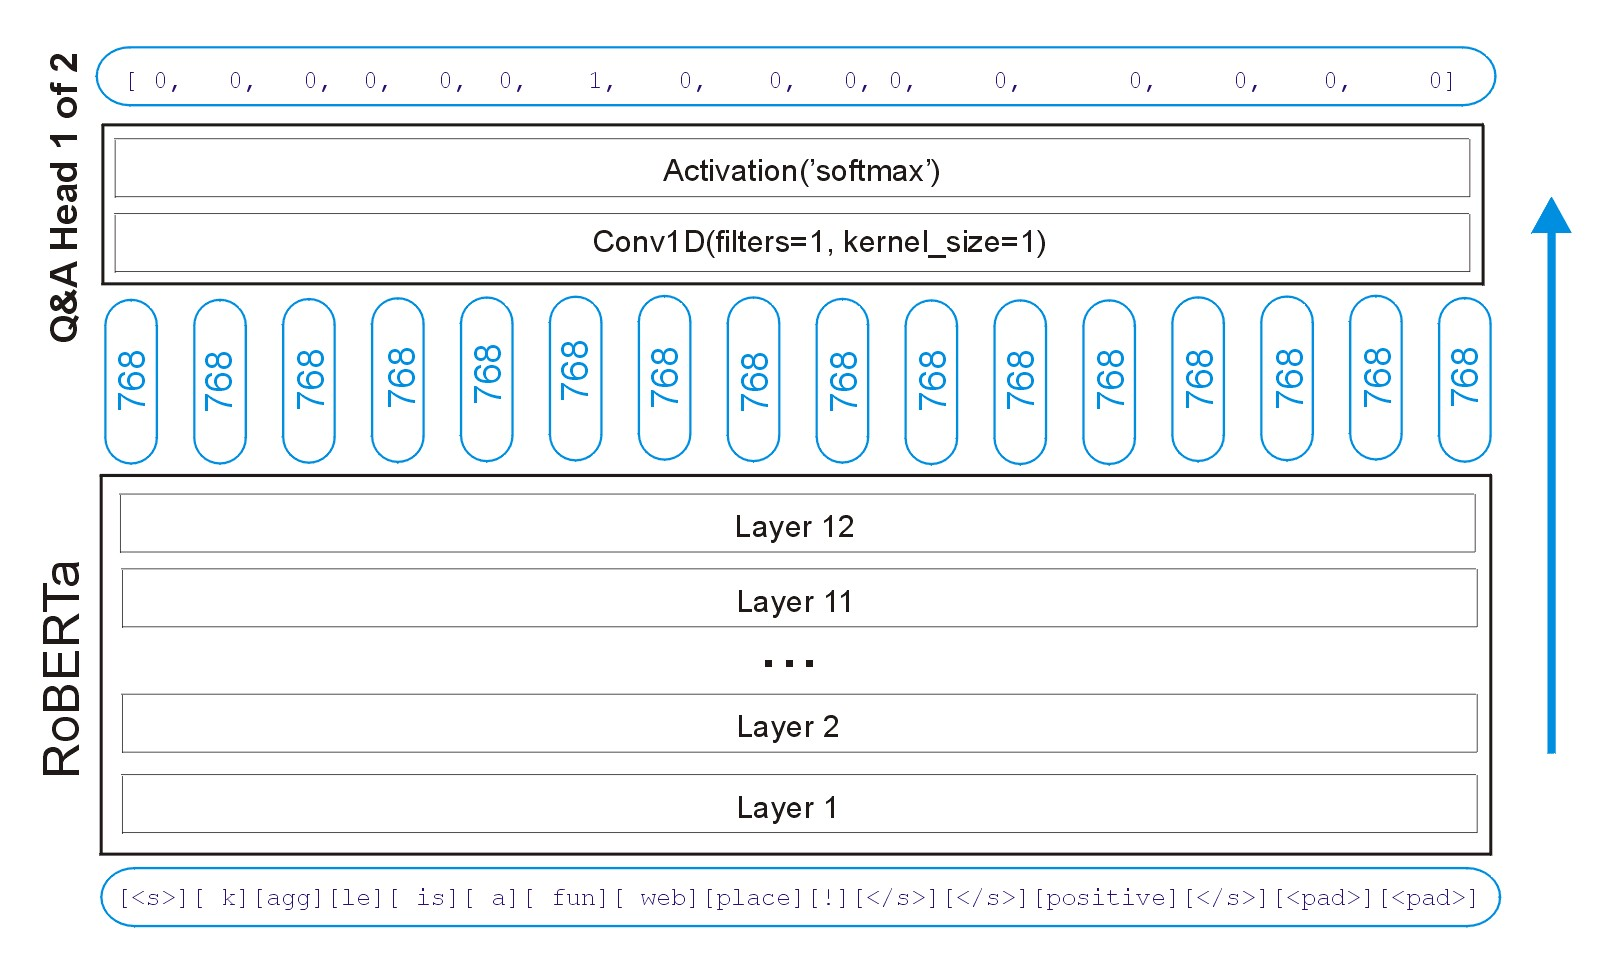

In [5]:
def build_model():
    ids = tf.keras.layers.Input((MAX_LEN,), dtype=tf.int32)
    att = tf.keras.layers.Input((MAX_LEN,), dtype=tf.int32)
    tok = tf.keras.layers.Input((MAX_LEN,), dtype=tf.int32)

    config = RobertaConfig.from_pretrained(PATH + 'config-roberta-base.json')
    bert_model = TFRobertaModel.from_pretrained(PATH + 'pretrained-roberta-base.h5', config=config)
    x = bert_model(ids, attention_mask=att, token_type_ids=tok)

    x1 = tf.keras.layers.Dropout(0.1)(x[0]) 
    x1 = tf.keras.layers.Conv1D(1, 1)(x1)
    x1 = tf.keras.layers.Flatten()(x1)
    x1 = tf.keras.layers.Activation('softmax')(x1)

    x2 = tf.keras.layers.Dropout(0.1)(x[0]) 
    x2 = tf.keras.layers.Conv1D(1, 1)(x2)
    x2 = tf.keras.layers.Flatten()(x2)
    x2 = tf.keras.layers.Activation('softmax')(x2)

    model = tf.keras.models.Model(inputs=[ids, att, tok], outputs=[x1, x2])
    optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer)

    return model


# Metric

In [7]:
def jaccard(str1, str2): 
    a = set(str1.lower().split()) 
    b = set(str2.lower().split())
    if (len(a) == 0) & (len(b) == 0): 
        return 0.5
    c = a.intersection(b)
    return float(len(c)) / (len(a) + len(b) - len(c))

# Train roBERTa Model
We train with 5 Stratified KFolds (based on sentiment stratification). Each fold, the best model weights are saved and then reloaded before oof prediction and test prediction. Therefore you can run this code offline and upload your 5 fold models to a private Kaggle dataset. Then run this notebook and comment out the line `model.fit()`. Instead your notebook will load your model weights from offline training in the line `model.load_weights()`. Update this to have the correct path. Also make sure you change the KFold seed below to match your offline training. Then this notebook will proceed to use your offline models to predict oof and predict test.

In [8]:

def build_advanced_conv_model():
    ids = tf.keras.layers.Input((MAX_LEN,), dtype=tf.int32)
    att = tf.keras.layers.Input((MAX_LEN,), dtype=tf.int32)
    tok = tf.keras.layers.Input((MAX_LEN,), dtype=tf.int32)

    # Load pre-trained RoBERTa model configuration and weights
    config = RobertaConfig.from_pretrained(PATH + 'config-roberta-base.json')
    bert_model = TFRobertaModel.from_pretrained(PATH + 'pretrained-roberta-base.h5', config=config)
    
    # Freeze the pooler layer (since it's not needed for span prediction)
    for layer in bert_model.layers:
        if "pooler" in layer.name:
            layer.trainable = False

    x = bert_model(ids, attention_mask=att, token_type_ids=tok)

    # Start logits branch (using Conv1D and LeakyReLU)
    x_start = tf.keras.layers.Dropout(0.1)(x[0])
    x_start = tf.keras.layers.Conv1D(filters=128, kernel_size=2, padding='same')(x_start)
    x_start = tf.keras.layers.LeakyReLU()(x_start)
    x_start = tf.keras.layers.Conv1D(filters=64, kernel_size=2, padding='same')(x_start)
    x_start = tf.keras.layers.LeakyReLU()(x_start)
    x_start = tf.keras.layers.Conv1D(filters=32, kernel_size=2, padding='same')(x_start)
    x_start = tf.keras.layers.Dense(units=1)(x_start)
    x_start = tf.keras.layers.LeakyReLU()(x_start)
    x_start = tf.keras.layers.Flatten()(x_start)
    x_start = tf.keras.layers.Activation('softmax')(x_start)

    # End logits branch (using Conv1D and LeakyReLU)
    x_end = tf.keras.layers.Dropout(0.1)(x[0])
    x_end = tf.keras.layers.Conv1D(filters=128, kernel_size=2, padding='same')(x_end)
    x_end = tf.keras.layers.LeakyReLU()(x_end)
    x_end = tf.keras.layers.Conv1D(filters=64, kernel_size=2, padding='same')(x_end)
    x_end = tf.keras.layers.LeakyReLU()(x_end)
    x_end = tf.keras.layers.Conv1D(filters=32, kernel_size=2, padding='same')(x_end)
    x_end = tf.keras.layers.Dense(units=1)(x_end)
    x_end = tf.keras.layers.LeakyReLU()(x_end)
    x_end = tf.keras.layers.Flatten()(x_end)
    x_end = tf.keras.layers.Activation('softmax')(x_end)

    # Define model with two output branches: one for start logits and one for end logits
    model = tf.keras.models.Model(inputs=[ids, att, tok], outputs=[x_start, x_end])

    # Use sparse_categorical_crossentropy for integer labels (token positions)
    optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer)

    return model


In [9]:
model = build_advanced_conv_model()
model.summary()

2024-10-24 15:16:41.990591: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-24 15:16:41.992593: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:925] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-10-24 15:16:41.992636: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:925] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-10-24 15:16:41.992653: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:925] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 96)]         0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 96)]         0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, 96)]         0           []                               
                                                                                                  
 tf_roberta_model (TFRobertaMod  TFBaseModelOutputWi  124645632  ['input_1[0][0]',                
 el)                            thPoolingAndCrossAt               'input_2[0][0]',            

In [10]:
import numpy as np
from sklearn.model_selection import StratifiedKFold
import tensorflow.keras.backend as K
import tensorflow as tf
from tensorflow.keras.mixed_precision import LossScaleOptimizer, set_global_policy

# Enable mixed precision globally
set_global_policy('mixed_float16')

def jaccard(str1, str2): 
    a = set(str1.lower().split()) 
    b = set(str2.lower().split())
    if (len(a) == 0) & (len(b) == 0): 
        return 0.5
    c = a.intersection(b)
    return float(len(c)) / (len(a) + len(b) - len(c))


def build_advanced_conv_model():
    ids = tf.keras.layers.Input((MAX_LEN,), dtype=tf.int32)
    att = tf.keras.layers.Input((MAX_LEN,), dtype=tf.int32)
    tok = tf.keras.layers.Input((MAX_LEN,), dtype=tf.int32)

    # Load pre-trained RoBERTa model configuration and weights
    config = RobertaConfig.from_pretrained(PATH + 'config-roberta-base.json')
    bert_model = TFRobertaModel.from_pretrained(PATH + 'pretrained-roberta-base.h5', config=config)
    
    # Freeze the pooler layer (since it's not needed for span prediction)
    for layer in bert_model.layers:
        if "pooler" in layer.name:
            layer.trainable = False

    x = bert_model(ids, attention_mask=att, token_type_ids=tok)

    # Start logits branch (using Conv1D and LeakyReLU)
    x_start = tf.keras.layers.Dropout(0.1)(x[0])
    x_start = tf.keras.layers.Conv1D(filters=128, kernel_size=2, padding='same')(x_start)
    x_start = tf.keras.layers.LeakyReLU()(x_start)
    x_start = tf.keras.layers.Conv1D(filters=64, kernel_size=2, padding='same')(x_start)
    x_start = tf.keras.layers.LeakyReLU()(x_start)
    x_start = tf.keras.layers.Conv1D(filters=32, kernel_size=2, padding='same')(x_start)
    x_start = tf.keras.layers.Dense(units=1)(x_start)
    x_start = tf.keras.layers.LeakyReLU()(x_start)
    x_start = tf.keras.layers.Flatten()(x_start)
    x_start = tf.keras.layers.Activation('softmax')(x_start)

    # End logits branch (using Conv1D and LeakyReLU)
    x_end = tf.keras.layers.Dropout(0.1)(x[0])
    x_end = tf.keras.layers.Conv1D(filters=128, kernel_size=2, padding='same')(x_end)
    x_end = tf.keras.layers.LeakyReLU()(x_end)
    x_end = tf.keras.layers.Conv1D(filters=64, kernel_size=2, padding='same')(x_end)
    x_end = tf.keras.layers.LeakyReLU()(x_end)
    x_end = tf.keras.layers.Conv1D(filters=32, kernel_size=2, padding='same')(x_end)
    x_end = tf.keras.layers.Dense(units=1)(x_end)
    x_end = tf.keras.layers.LeakyReLU()(x_end)
    x_end = tf.keras.layers.Flatten()(x_end)
    x_end = tf.keras.layers.Activation('softmax')(x_end)

    # Define model with two output branches: one for start logits and one for end logits
    model = tf.keras.models.Model(inputs=[ids, att, tok], outputs=[x_start, x_end])

    # Use sparse_categorical_crossentropy for integer labels (token positions)
    optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer)

    return model


# Main training loop with Stratified KFold cross-validation
jac = []
VER = 'v0'
DISPLAY = 1  # Enable verbose display
oof_start = np.zeros((input_ids.shape[0], MAX_LEN))
oof_end = np.zeros((input_ids.shape[0], MAX_LEN))
preds_start = np.zeros((input_ids_t.shape[0], MAX_LEN))
preds_end = np.zeros((input_ids_t.shape[0], MAX_LEN))

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=777)

for fold, (idxT, idxV) in enumerate(skf.split(input_ids, train.sentiment.values)):

    print('#' * 25)
    print(f'### FOLD {fold + 1}')
    print('#' * 25)
    
    K.clear_session()
    model = build_advanced_conv_model()

    # Debug the shapes before training
    print("Training start_tokens shape:", start_tokens[idxT].shape)
    print("Training end_tokens shape:", end_tokens[idxT].shape)

    # Ensure start_tokens and end_tokens are integer arrays of shape (batch_size,)
    start_train = start_tokens[idxT] # Get the index positions of the start token
    end_train = end_tokens[idxT]      # Get the index positions of the end token
    start_valid = start_tokens[idxV]
    end_valid = end_tokens[idxV]

    # Print shapes for debugging
    print("Training start_train shape:", start_train.shape)
    print("Training end_train shape:", end_train.shape)
    
    # ModelCheckpoint callback to save best model during each fold
    sv = tf.keras.callbacks.ModelCheckpoint(
        '%s-roberta-%i.h5' % (VER, fold), monitor='val_loss', verbose=1, save_best_only=True,
        save_weights_only=True, mode='auto', save_freq='epoch'
    )
    
    # Training the model on the training set (idxT)
    print('Training model...')
    model.fit(
        [input_ids[idxT,], attention_mask[idxT,], token_type_ids[idxT,]],  # Input tensors
        [start_train, end_train],  # Integer token positions
        epochs=3,  # Increased epochs to 5
        batch_size=32,  # Keeping batch size as 32 for efficient training
        verbose=DISPLAY, callbacks=[sv],
        validation_data=([input_ids[idxV,], attention_mask[idxV,], token_type_ids[idxV,]], 
                         [start_valid, end_valid])  # Integer validation labels
    )
    
    # Load the best weights from training
    print('Loading best model weights...')
    model.load_weights('%s-roberta-%i.h5' % (VER, fold))
    
    # Predicting OOF for the current fold
    print('Predicting OOF...')
    oof_start[idxV,], oof_end[idxV,] = model.predict(
        [input_ids[idxV,], attention_mask[idxV,], token_type_ids[idxV,]], 
        verbose=DISPLAY, 
        batch_size=8
    )

    # Predicting on the test set
    print('Predicting Test...')
    preds = model.predict(
        [input_ids_t, attention_mask_t, token_type_ids_t], 
        verbose=DISPLAY, 
        batch_size=8 
    )
    preds_start += preds[0] / skf.n_splits
    preds_end += preds[1] / skf.n_splits

    # DISPLAY FOLD JACCARD
    all = []
    for k in idxV:
        a = np.argmax(oof_start[k,])
        b = np.argmax(oof_end[k,])

        # Check if indices are valid, else swap or fix bounds
        if a > b:
            a, b = b, a  # Swap indices if they are in the wrong order
        if b >= MAX_LEN:
            b = MAX_LEN - 1  # Clip the end index to the maximum allowed length
        
        text1 = " " + " ".join(train.loc[k, 'text'].split())
        enc = tokenizer.encode(text1)
        
        if a > 0 and b > 0:
            st = tokenizer.decode(enc.ids[a-1:b])
        else:
            st = train.loc[k, 'text']  # Default to full text if indices are invalid

        # Calculate Jaccard score
        jaccard_score = jaccard(st, train.loc[k, 'selected_text'])
        all.append(jaccard_score)

    fold_jaccard = np.mean(all)
    jac.append(fold_jaccard)
    print(f'>>>> FOLD {fold + 1} Jaccard =', fold_jaccard)
    print()


#########################
### FOLD 1
#########################


All model checkpoint layers were used when initializing TFRobertaModel.

All the layers of TFRobertaModel were initialized from the model checkpoint at ../config/pretrained-roberta-base.h5.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


Training start_tokens shape: (21984, 96)
Training end_tokens shape: (21984, 96)
Training start_train shape: (21984, 96)
Training end_train shape: (21984, 96)
Training model...
Epoch 1/3


: 

In [17]:
# Start debugging for fold 1 only
jac = []
VER = 'v0'
DISPLAY = 0  # Set to 1 if you want to see more verbose outputs from Keras
oof_start = np.zeros((input_ids.shape[0], MAX_LEN))
oof_end = np.zeros((input_ids.shape[0], MAX_LEN))
preds_start = np.zeros((input_ids_t.shape[0], MAX_LEN))
preds_end = np.zeros((input_ids_t.shape[0], MAX_LEN))

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=777)

# Only do fold 1 for debugging
fold = 0
idxT, idxV = list(skf.split(input_ids, train.sentiment.values))[fold]

print('#' * 25)
print(f'### FOLD {fold + 1}')
print('#' * 25)

K.clear_session()
model = build_model()

model_path = '../models/weights_final.h5'

# Load pre-trained weights
print('Loading model...')
model.load_weights(model_path)

print('Predicting OOF...')
oof_start[idxV,], oof_end[idxV,] = model.predict(
    [input_ids[idxV,], attention_mask[idxV,], token_type_ids[idxV,]], 
    verbose=DISPLAY, 
    batch_size=8  # Reduce batch size for memory efficiency
)

# Debugging OOF predictions for fold 1
all = []
for k in idxV:
    a = np.argmax(oof_start[k,])
    b = np.argmax(oof_end[k,])

    # Debugging: Print start and end logits for a few samples
    if k in [5, 22]:  # Add more sample indices if needed
        print(f'\nLogits for sample {k}:')
        print(f'Start logits: {oof_start[k,]}')
        print(f'End logits: {oof_end[k,]}')

    # Continue with previous debugging code for spans
    print(f'\nSample {k}:')
    print(f'Predicted start index: {a}, Predicted end index: {b}')
    
    if a > b:
        print("Warning: Start index is greater than end index. Swapping.")
        a, b = b, a
    if b >= MAX_LEN:
        print(f'Warning: End index {b} exceeds MAX_LEN {MAX_LEN}. Clipping to {MAX_LEN - 1}.')
        b = MAX_LEN - 1

    text1 = " " + " ".join(train.loc[k, 'text'].split())
    enc = tokenizer.encode(text1)

    if a > 0 and b > 0:
        st = tokenizer.decode(enc.ids[a-1:b])
    else:
        print("Warning: Invalid span. Using original text.")
        st = train.loc[k, 'text']

    print(f'Predicted text: "{st}"')
    print(f'Ground truth text: "{train.loc[k, "selected_text"]}"')

    jaccard_score = jaccard(st, train.loc[k, 'selected_text'])
    print(f'Jaccard score: {jaccard_score}')
    all.append(jaccard_score)

# Calculate and display the Jaccard score for Fold 1
fold_jaccard = np.mean(all)
jac.append(fold_jaccard)
print(f'>>>> FOLD {fold + 1} Jaccard =', fold_jaccard)


#########################
### FOLD 1
#########################


All model checkpoint layers were used when initializing TFRobertaModel.

All the layers of TFRobertaModel were initialized from the model checkpoint at ../config/pretrained-roberta-base.h5.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


  opt = tf.keras.mixed_precision.LossScaleOptimizer(opt)

Loading model...
Predicting OOF...

Logits for sample 5:
Start logits: [0.01041412 0.01041412 0.01041412 0.01041412 0.01041412 0.01041412
 0.01041412 0.01041412 0.01041412 0.01041412 0.01041412 0.01041412
 0.01041412 0.01041412 0.01041412 0.01041412 0.01041412 0.01041412
 0.01041412 0.01041412 0.01041412 0.01041412 0.01041412 0.01041412
 0.01041412 0.01041412 0.01041412 0.01041412 0.01041412 0.01041412
 0.01041412 0.01041412 0.01041412 0.01041412 0.01041412 0.01041412
 0.01041412 0.01041412 0.01041412 0.01041412 0.01041412 0.01041412
 0.01041412 0.01041412 0.01041412 0.01041412 0.01041412 0.01041412
 0.01041412 0.01041412 0.01041412 0.01041412 0.01041412 0.01041412
 0.01041412 0.01041412 0.01041412 0.01041412 0.01041412 0.01041412
 0.01041412 0.01041412 0.01041412 0.01041412 0.01041412 0.01041412
 0.01041412 0.01041412 0.01041412 0.01041412 0.01041412 0.01041412
 0.01041412 0.01041412 0.01041412 0.01041412 0.01041412 0.01041412


In [9]:
jac = []
VER = 'v0'
DISPLAY = 0  # Use display=1 for interactive
oof_start = np.zeros((input_ids.shape[0], MAX_LEN))
oof_end = np.zeros((input_ids.shape[0], MAX_LEN))
preds_start = np.zeros((input_ids_t.shape[0], MAX_LEN))
preds_end = np.zeros((input_ids_t.shape[0], MAX_LEN))

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=777)

for fold, (idxT, idxV) in enumerate(skf.split(input_ids, train.sentiment.values)):

    print('#' * 25)
    print('### FOLD %i' % (fold + 1))
    print('#' * 25)
    
    K.clear_session()
    model = build_model()
    
    
    # sv = tf.keras.callbacks.ModelCheckpoint(
    #     '%s-roberta-%i.h5'%(VER,fold), monitor='val_loss', verbose=1, save_best_only=True,
    #     save_weights_only=True, mode='auto', save_freq='epoch')
        
    # model.fit([input_ids[idxT,], attention_mask[idxT,], token_type_ids[idxT,]], [start_tokens[idxT,], end_tokens[idxT,]], 
    #     epochs=3, batch_size=32, verbose=DISPLAY, callbacks=[sv],
    #     validation_data=([input_ids[idxV,],attention_mask[idxV,],token_type_ids[idxV,]], 
    #     [start_tokens[idxV,], end_tokens[idxV,]]))
    
    # print('Loading model...')
    # model.load_weights('%s-roberta-%i.h5'%(VER,fold))
    
    
    model_path = '../models/weights_final.h5'
    
    # Loading pre-trained weights instead of training
    print('Loading model...')
    model.load_weights(model_path)
    
    print('Predicting OOF...')
    oof_start[idxV,], oof_end[idxV,] = model.predict(
        [input_ids[idxV,], attention_mask[idxV,], token_type_ids[idxV,]], 
        verbose=DISPLAY, 
        batch_size=8  # Reduce batch size for memory efficiency
    )

    print('Predicting Test...')
    preds = model.predict(
        [input_ids_t, attention_mask_t, token_type_ids_t], 
        verbose=DISPLAY, 
        batch_size=8 
    )
    preds_start += preds[0] / skf.n_splits
    preds_end += preds[1] / skf.n_splits

    # DISPLAY FOLD JACCARD
    all = []
    for k in idxV:
        a = np.argmax(oof_start[k,])
        b = np.argmax(oof_end[k,])

        # Check if indices are valid, else swap or fix bounds
        if a > b:
            a, b = b, a  # Swap indices if they are in the wrong order
        if b >= MAX_LEN:
            b = MAX_LEN - 1  # Clip the end index to the maximum allowed length
        
        text1 = " " + " ".join(train.loc[k, 'text'].split())
        enc = tokenizer.encode(text1)
        
        if a > 0 and b > 0:
            st = tokenizer.decode(enc.ids[a-1:b])
        else:
            st = train.loc[k, 'text']  # Default to full text if indices are invalid

        # Calculate Jaccard score
        jaccard_score = jaccard(st, train.loc[k, 'selected_text'])
        all.append(jaccard_score)

    fold_jaccard = np.mean(all)
    jac.append(fold_jaccard)
    print(f'>>>> FOLD {fold + 1} Jaccard =', fold_jaccard)
    print()

#########################
### FOLD 1
#########################


All model checkpoint layers were used when initializing TFRobertaModel.

All the layers of TFRobertaModel were initialized from the model checkpoint at ../config/pretrained-roberta-base.h5.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


  opt = tf.keras.mixed_precision.LossScaleOptimizer(opt)

Loading model...
Predicting OOF...
Predicting Test...
>>>> FOLD 1 Jaccard = 0.5965363469046548

#########################
### FOLD 2
#########################


All model checkpoint layers were used when initializing TFRobertaModel.

All the layers of TFRobertaModel were initialized from the model checkpoint at ../config/pretrained-roberta-base.h5.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


  opt = tf.keras.mixed_precision.LossScaleOptimizer(opt)

Loading model...
Predicting OOF...
Predicting Test...
>>>> FOLD 2 Jaccard = 0.5903057955860458

#########################
### FOLD 3
#########################


All model checkpoint layers were used when initializing TFRobertaModel.

All the layers of TFRobertaModel were initialized from the model checkpoint at ../config/pretrained-roberta-base.h5.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


  opt = tf.keras.mixed_precision.LossScaleOptimizer(opt)

Loading model...
Predicting OOF...
Predicting Test...
>>>> FOLD 3 Jaccard = 0.5910442805906191

#########################
### FOLD 4
#########################


All model checkpoint layers were used when initializing TFRobertaModel.

All the layers of TFRobertaModel were initialized from the model checkpoint at ../config/pretrained-roberta-base.h5.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


  opt = tf.keras.mixed_precision.LossScaleOptimizer(opt)

Loading model...
Predicting OOF...
Predicting Test...
>>>> FOLD 4 Jaccard = 0.5784787933730345

#########################
### FOLD 5
#########################


All model checkpoint layers were used when initializing TFRobertaModel.

All the layers of TFRobertaModel were initialized from the model checkpoint at ../config/pretrained-roberta-base.h5.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


  opt = tf.keras.mixed_precision.LossScaleOptimizer(opt)

Loading model...
Predicting OOF...
Predicting Test...
>>>> FOLD 5 Jaccard = 0.588999159263832



In [13]:
print('>>>> OVERALL 5Fold CV Jaccard =',np.mean(jac))

>>>> OVERALL 5Fold CV Jaccard = 0.5890728751436372


# Kaggle Submission

In [14]:
all = []
for k in range(input_ids_t.shape[0]):
    a = np.argmax(preds_start[k,])
    b = np.argmax(preds_end[k,])
    if a>b: 
        st = test.loc[k,'text']
    else:
        text1 = " "+" ".join(test.loc[k,'text'].split())
        enc = tokenizer.encode(text1)
        st = tokenizer.decode(enc.ids[a-1:b])
    all.append(st)

In [15]:
test['selected_text'] = all
test[['textID','selected_text']].to_csv('submission.csv',index=False)
pd.set_option('max_colwidth', 60)
test.sample(25)

,textID,text,sentiment,selected_text
715,13632b763a,I remember those days. I wasn`t a big fan of Wesley bu...,neutral,
1799,d1aa96a414,'Patchouli oil & incense had a surge in popularity in th...,positive,
1457,112da4faa0,Gonna go and see my sister at Mount Saini .... she`s th...,neutral,
1279,7013b54ea6,"_ Heading off to Poole around 4ish, has some serious ga...",negative,
1941,3592e3ebc9,Good luck at the services tomorrow!! I wish I could see...,positive,
3009,881affa1a2,yeaaaah tangerang in vacation,neutral,
2824,11a3a0fb9d,Thank you. Usually the learning happens after I get a ...,positive,
941,b03e2a23e5,"_tdh Can you install ruby, gems and rails on keep? Please?",neutral,
303,8bbaca6e4b,I have not tweeted for SIXTEEN DAYS! I miss it =( I`ve b...,neutral,
3200,88040d7737,thanks to follow. have a nice rest,positive,
